<a href="https://colab.research.google.com/github/priyanandhasivane24bds144-dev/PROJECT/blob/main/PRIYANANDHASIVAN_E(24BDS144).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✔ Dataset Loaded Successfully!

    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                             6                       6   
3               

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, 

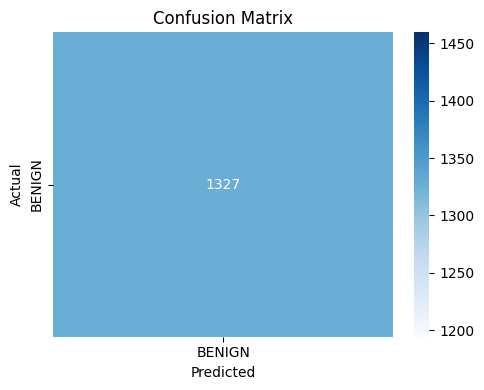

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


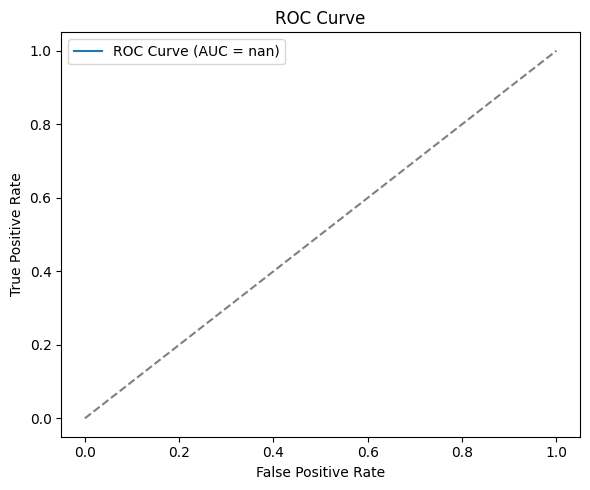

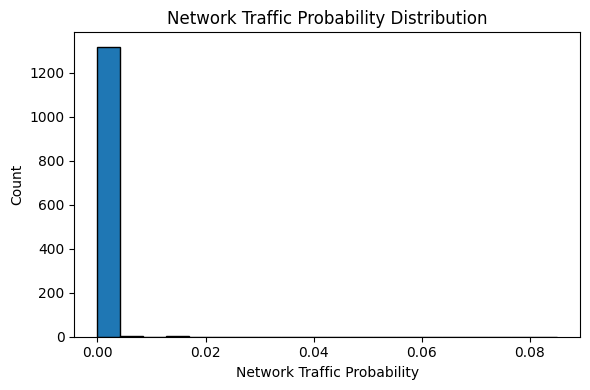


=== SAMPLE PREDICTION ===
Network Traffic Prediction : BENIGN
Network Traffic Probability: 0.0


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)
from sklearn.impute import SimpleImputer
import numpy as np

dn_df = pd.read_csv('/content/combine.csv')

print('✔ Dataset Loaded Successfully!\n')
print(dn_df.head())

print('\nOriginal DataFrame columns:', dn_df.columns.tolist())

dn_df.columns = dn_df.columns.str.strip()

print('DataFrame columns (after stripping whitespace):', dn_df.columns.tolist())

dn_df.dropna(subset=['Label'], inplace=True)
print(f'\nDropped rows with NaN in "Label" column. New dataset size: {len(dn_df)} rows')

X = dn_df.drop('Label', axis=1)
y = dn_df['Label']

X.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"Number of infinite values replaced with NaN in X: {X.isin([np.inf, -np.inf]).sum().sum()}")

numeric_cols = X.select_dtypes(include=['int64','float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


model.fit(X_train, y_train)
print('\n✔ Model Training Completed!')

y_pred = model.predict(X_test)

positive_class = 'DDoS'

classifier_classes = model.named_steps['classifier'].classes_
print(f"Classifier classes: {classifier_classes}")

if positive_class in classifier_classes:
    positive_class_idx = list(classifier_classes).index(positive_class)
    y_prob = model.predict_proba(X_test)[:, positive_class_idx]
else:

    print(f"Warning: Positive class '{positive_class}' not found in classifier classes. Defaulting to first class probability.")
    y_prob = model.predict_proba(X_test)[:, 0]

print('\n============= MODEL PERFORMANCE =============')
print('Accuracy  :', accuracy_score(y_test, y_pred))

y_test_binary = (y_test == positive_class).astype(int)
y_pred_binary = (y_pred == positive_class).astype(int)

print('Precision :', precision_score(y_test_binary, y_pred_binary))
print('Recall    :', recall_score(y_test_binary, y_pred_binary))

print('ROC-AUC   :', roc_auc_score(y_test_binary, y_prob))
print('==============================================\n')

labels_in_data = sorted(y_test.unique())

cm = confusion_matrix(y_test, y_pred, labels=labels_in_data)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_in_data,
            yticklabels=labels_in_data)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=positive_class)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(y_prob, bins=20, edgecolor='black')
plt.title("Network Traffic Probability Distribution")
plt.xlabel("Network Traffic Probability")
plt.ylabel('Count')
plt.tight_layout()
plt.show()

sample_data_for_prediction = {}
for col in X.columns:
    if col in numeric_cols:
        sample_data_for_prediction[col] = [0.0]
    elif col in categorical_cols:
        sample_data_for_prediction[col] = ['']
    else:
        sample_data_for_prediction[col] = [None]

sample = pd.DataFrame(sample_data_for_prediction)

pred = model.predict(sample)[0]

if positive_class in classifier_classes:
    sample_positive_class_idx = list(classifier_classes).index(positive_class)
    prob = model.predict_proba(sample)[0][sample_positive_class_idx]
else:
    prob = model.predict_proba(sample)[0][0]
print('\n=== SAMPLE PREDICTION ===')
print('Network Traffic Prediction :', pred)
print('Network Traffic Probability:', prob)